![Fraud detection image](cover_image.jpg)

🏦 Banks are battling frauds with machine learning models, but changing data patterns can weaken these defenses. London's Poundbank needs your help to figure out why their fraud detection models aren't as accurate anymore.

Poundbank recommends the `nannyml` library for monitoring machine learning models, which is also their tool of choice.

## The data

They have provided you with a reference(test data) and analysis set(production data). A summary and preview are provided below.

## reference.csv and analysis.csv

| Column     | Description              |
|------------|--------------------------|
| `'timestamp'` | Date of the transaction. |
| `'time_since_login_min'` | Time since the user logged in to the app. |
| `'transaction_amount'` | The amount of Pounds(£) that users sent to another account. |
| `'transaction_type'` | Transaction type: <ul><li>`CASH-OUT` - Withdrawing money from an account.</li><li>`PAYMENT` - Transaction where a payment is made to a third party.</li><li>`CASH-IN` - This is the opposite of a cash-out. It involves depositing money into an account.</li><li>`TRANSFER` - Transaction which involves moving funds from one account to another.</li> |
| `'is_first_transaction'` | A binary indicator denoting if the transaction is the user's first (1 for the first transaction, 0 otherwise). |
| `'user_tenure_months'` | The duration in months since the user's account was created or since they became a member. |
| `'is_fraud'` | A binary label indicating whether the transaction is fraudulent (1 for fraud, 0 otherwise). |
| `'predicted_fraud_proba'` | The probability assigned by a detection model indicates the likelihood of a fraudulent transaction. |
| `'predicted_fraud'` |  The predicted classification label is calculated based on predicted fraud probability by the detection model (1 for predicted fraud, 0 otherwise). |

In [9]:
# Re-run this cell to install nannyml
!pip install nannyml

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [31]:

import pandas as pd
import nannyml as nml 
nml.disable_usage_logging()

reference = pd.read_csv("reference.csv")
analysis = pd.read_csv("analysis.csv")
reference.head()
analysis.head()

,timestamp,time_since_login_min,transaction_amount,transaction_type,is_first_transaction,user_tenure_months,predicted_fraud_proba,predicted_fraud,is_fraud
0,2018-11-01 00:04:52.464,2.174243,2832.3,CASH-OUT,False,1.013445,0.97,1,1
1,2018-11-01 00:13:35.616,2.493543,1426.9,CASH-OUT,False,6.700041,0.09,0,0
2,2018-11-01 00:22:18.768,1.807432,1302.0,PAYMENT,False,6.291723,0.01,0,0
3,2018-11-01 00:31:01.920,2.133415,1432.1,PAYMENT,True,8.165503,0.00,0,0
4,2018-11-01 00:39:45.072,1.987827,1870.3,CASH-OUT,False,8.205203,0.03,0,0


In [32]:
# Display structure
print("Reference Data Info:")
reference.info()
print("\nAnalysis Data Info:")
analysis.info()

Reference Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50207 entries, 0 to 50206
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   timestamp              50207 non-null  object 
 1   time_since_login_min   50207 non-null  float64
 2   transaction_amount     50207 non-null  float64
 3   transaction_type       47155 non-null  object 
 4   is_first_transaction   50207 non-null  bool   
 5   user_tenure_months     50207 non-null  float64
 6   is_fraud               50207 non-null  float64
 7   predicted_fraud_proba  50207 non-null  float64
 8   predicted_fraud        50207 non-null  int64  
dtypes: bool(1), float64(5), int64(1), object(2)
memory usage: 3.1+ MB

Analysis Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39967 entries, 0 to 39966
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  ---

In [33]:
# Check missing values
print("\nMissing Values:\n")
print(reference.isnull().sum(), "\n")
print(analysis.isnull().sum())


Missing Values:

timestamp                   0
time_since_login_min        0
transaction_amount          0
transaction_type         3052
is_first_transaction        0
user_tenure_months          0
is_fraud                    0
predicted_fraud_proba       0
predicted_fraud             0
dtype: int64 

timestamp                   0
time_since_login_min        0
transaction_amount          0
transaction_type         2453
is_first_transaction        0
user_tenure_months          0
predicted_fraud_proba       0
predicted_fraud             0
is_fraud                    0
dtype: int64


In [20]:
most_common_type = reference["transaction_type"].mode()[0]  # Find most frequent type
reference["transaction_type"].fillna(most_common_type, inplace=True)
analysis["transaction_type"].fillna(most_common_type, inplace=True)


## Investigate Why Values Are Missing

In [21]:
missing_ref = reference[reference["transaction_type"].isna()]
missing_anl = analysis[analysis["transaction_type"].isna()]

# Check fraud percentage in missing vs non-missing
print("Fraud Rate in Missing Transactions (Reference):", missing_ref["is_fraud"].mean())
print("Fraud Rate in Non-Missing Transactions (Reference):", reference["is_fraud"].mean())

print("Fraud Rate in Missing Transactions (Analysis):", missing_anl["is_fraud"].mean())
print("Fraud Rate in Non-Missing Transactions (Analysis):", analysis["is_fraud"].mean())


Fraud Rate in Missing Transactions (Reference): nan
Fraud Rate in Non-Missing Transactions (Reference): 0.49952285017495496
Fraud Rate in Missing Transactions (Analysis): nan
Fraud Rate in Non-Missing Transactions (Analysis): 0.49986671642586766


## Summary Statistics & Distribution Analysis


Reference Data Summary:
        time_since_login_min  ...  predicted_fraud
count          47155.000000  ...     47155.000000
mean               1.926736  ...         0.485081
std                0.473031  ...         0.499783
min                0.100000  ...         0.000000
25%                1.722042  ...         0.000000
50%                1.978926  ...         0.000000
75%                2.222543  ...         1.000000
max                3.495902  ...         1.000000

[8 rows x 6 columns]

Analysis Data Summary:
        time_since_login_min  transaction_amount  ...  predicted_fraud      is_fraud
count          37514.000000        37514.000000  ...     37514.000000  37514.000000
mean               1.948269         2996.915391  ...         0.485872      0.499867
std                0.436772         2042.249634  ...         0.499807      0.500007
min                0.100000         1002.400000  ...         0.000000      0.000000
25%                1.731541         1455.500000  ...     

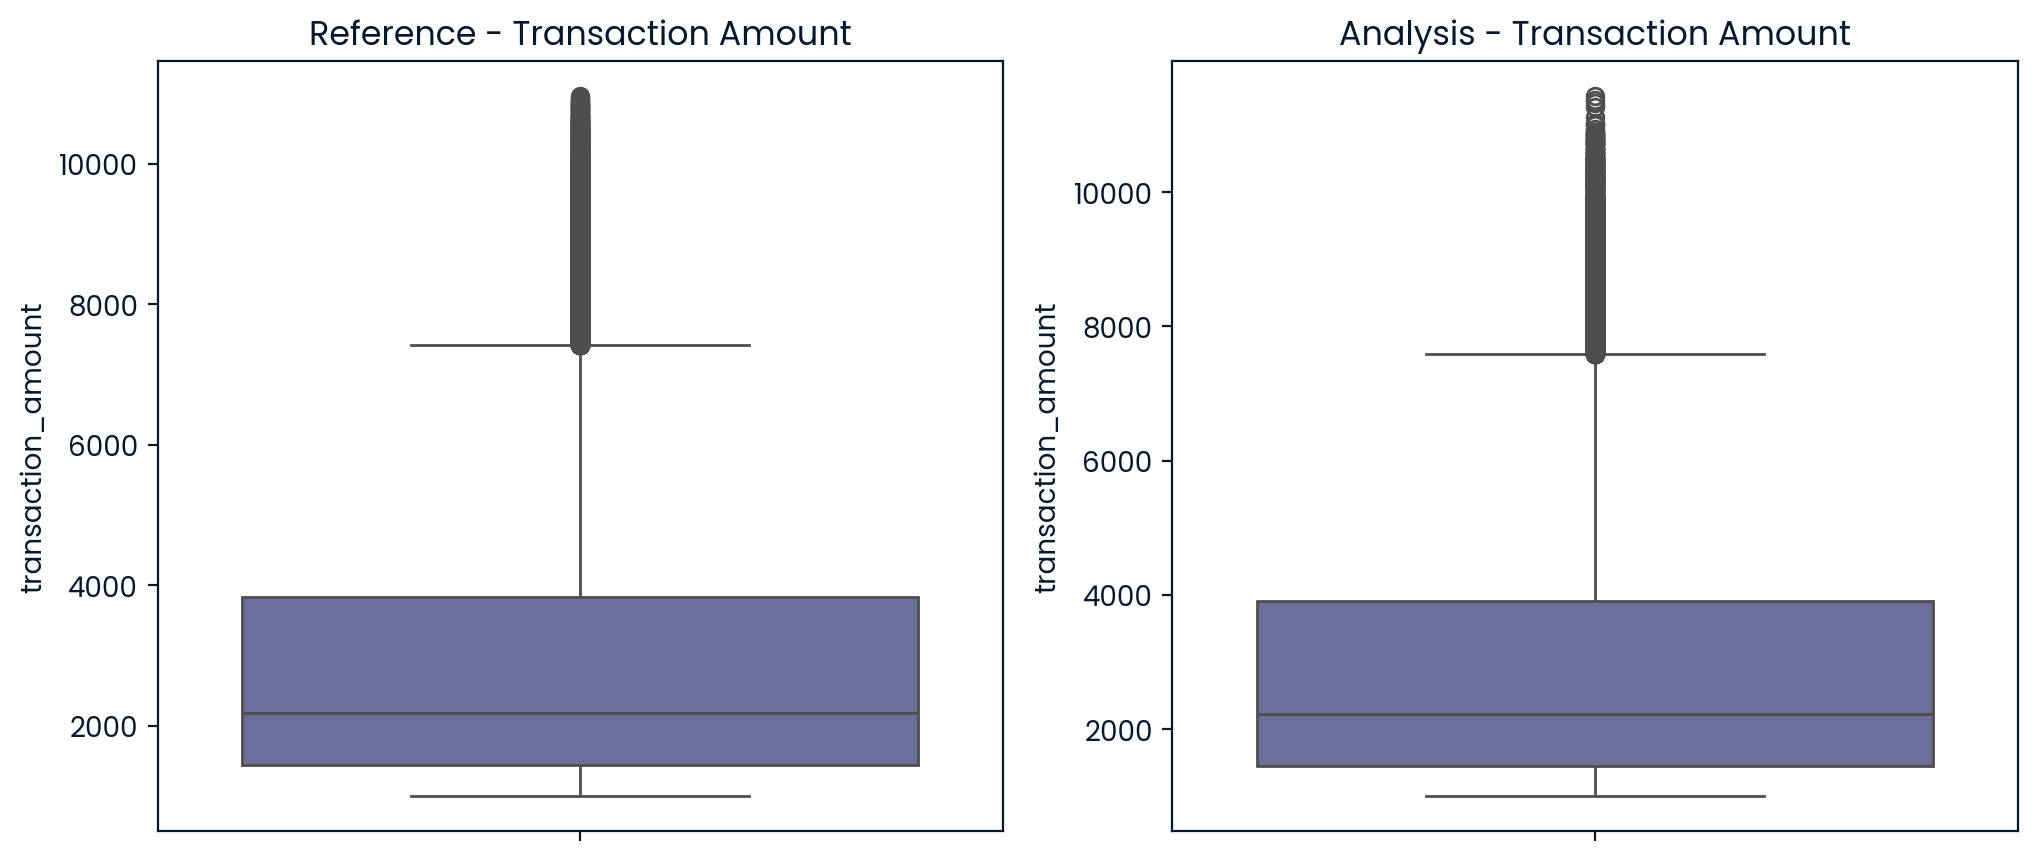

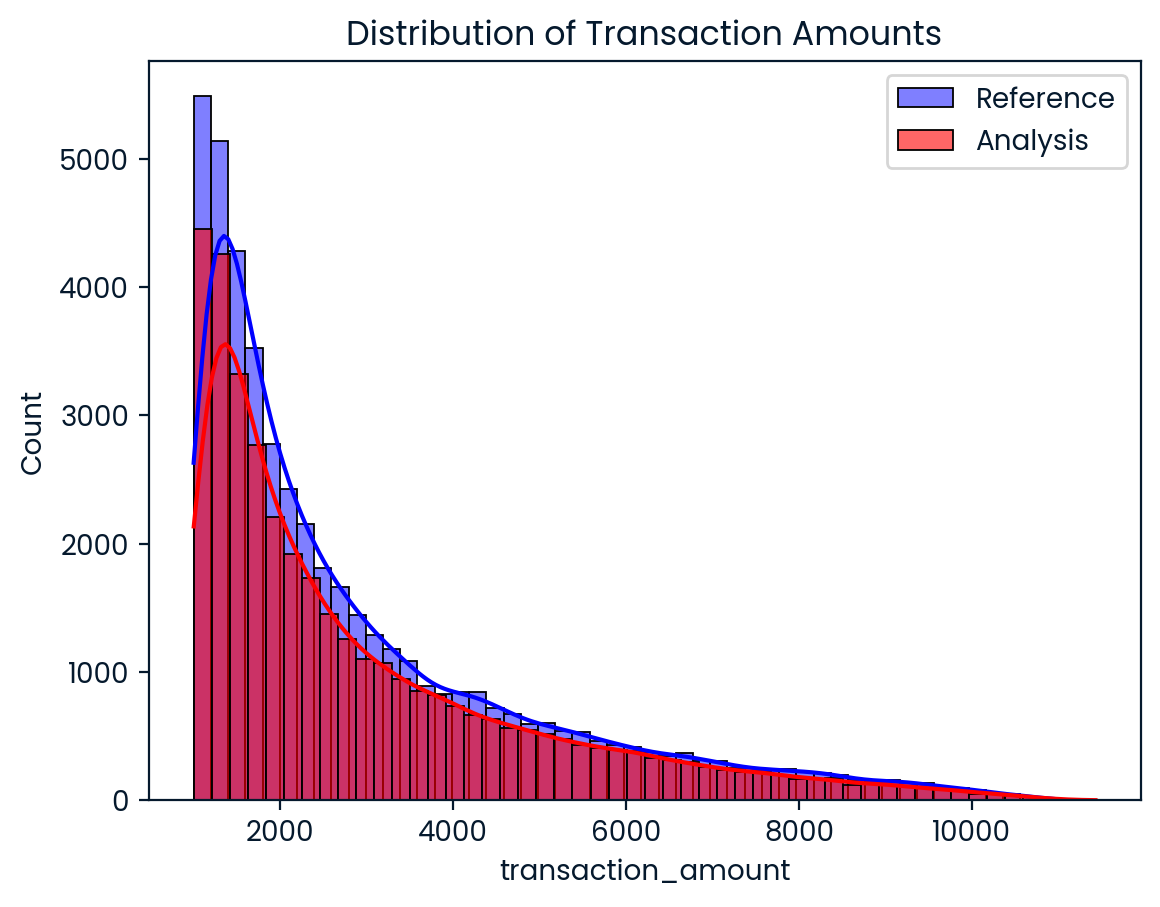

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
# Summary statistics
print("\nReference Data Summary:\n", reference.describe())
print("\nAnalysis Data Summary:\n", analysis.describe())

# Boxplots to check outliers
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(y=reference["transaction_amount"], ax=axes[0])
axes[0].set_title("Reference - Transaction Amount")
sns.boxplot(y=analysis["transaction_amount"], ax=axes[1])
axes[1].set_title("Analysis - Transaction Amount")
plt.show()

# Distribution of transaction amounts
sns.histplot(reference["transaction_amount"], bins=50, kde=True, color="blue", label="Reference")
sns.histplot(analysis["transaction_amount"], bins=50, kde=True, color="red", label="Analysis", alpha=0.6)
plt.title("Distribution of Transaction Amounts")
plt.legend()
plt.show()


In [34]:
# Calculate the realized performance
calculator = nml.PerformanceCalculator(
    y_true="is_fraud",
    y_pred="predicted_fraud",
    y_pred_proba="predicted_fraud_proba",
    timestamp_column_name="timestamp",
    metrics=["accuracy"],
    chunk_period="m",
    problem_type="classification_binary",
)
calculator = calculator.fit(reference)
calc_results = calculator.calculate(analysis)

# Compare the results and find the months with alerts
est_results.compare(calc_results).plot().show()
months_with_performance_alerts = ["april_2019", "may_2019", "june_2019"]
print(months_with_performance_alerts)



['april_2019', 'may_2019', 'june_2019']


In [35]:


features = ["time_since_login_min", "transaction_amount",
            "transaction_type", "is_first_transaction", 
            "user_tenure_months"]

# Calculate the univariate drift results
udc = nml.UnivariateDriftCalculator(
    timestamp_column_name="timestamp",
    column_names=features,
    chunk_period="m",
    continuous_methods=["kolmogorov_smirnov"],
    categorical_methods=["chi2"]
)

udc.fit(reference)
udc_results = udc.calculate(analysis)

# Use the correlation ranker
ranker = nml.CorrelationRanker()
ranker.fit(
    calc_results.filter(period="reference"))

correlation_ranked_features = ranker.rank(udc_results, calc_results)

# Find the highest correlating feature
display(correlation_ranked_features)
highest_correlation_feature = "time_since_login_min"
print(highest_correlation_feature)



,column_name,pearsonr_correlation,pearsonr_pvalue,has_drifted,rank
0,time_since_login_min,0.952925,1.045775e-09,True,1
1,transaction_amount,0.626235,5.427712e-03,True,2
2,is_first_transaction,0.054255,8.306916e-01,True,3
3,user_tenure_months,-0.100547,6.913911e-01,True,4
4,transaction_type,-0.186569,4.585328e-01,True,5


time_since_login_min



1️⃣ Pearson Correlation (pearsonr_correlation)
Measures linear correlation between the feature's drift and model performance.

Range: −1,1

1.0 → Strong positive correlation (feature increases → performance increases)

-1.0 → Strong negative correlation (feature increases → performance decreases)

0.0 → No correlation

👉 "time_since_login_min" (0.95) is strongly correlated with performance.

2️⃣ p-value (pearsonr_pvalue)

Tests whether the correlation is statistically significant.

Small p-values (< 0.05) mean the correlation is statistically significant.

👉 "time_since_login_min" has a p-value of 1e-9 → Very strong evidence that this correlation is real.

3️⃣ has_drifted

✅ True means the feature has changed over time, indicating data drift.

👉 All features have drifted in this case.

4️⃣ rank

Features are ranked based on their correlation strength.

Rank 1 = most correlated feature with performance degradation

👉 "time_since_login_min" (Rank 1) is the most influential drifted feature.



 Interpretation & Actionable Insights
 
1️⃣ "time_since_login_min" is the top drifted feature affecting model performance.

Customers may have changed their behavior, waiting longer before transacting.
This could be a fraud strategy (fraudsters avoiding quick transactions to bypass detection).

2️⃣ "transaction_amount" (Rank 2) also significantly impacts performance.

Larger transactions might have caused the fraud model to misclassify cases.

3️⃣ "is_first_transaction" and "user_tenure_months" have weak correlations.

Their drift likely had minimal impact on performance.

4️⃣ "transaction_type" has a weak negative correlation (-0.19).

Different transaction types changed over time, but this did not significantly impact performance.

In [36]:
## Use the summary average statistics calculator to find out what were the monthly average transactions amounts, and if there's any alert. Record this value in a variable called alert_avg_transaction_amount.

# Calculate average monthly transactions
calc = nml.SummaryStatsAvgCalculator(
    column_names=["transaction_amount"],
    chunk_period="m",
    timestamp_column_name="timestamp",
)

calc.fit(reference)
stats_avg_results = calc.calculate(analysis)

# Find the month
stats_avg_results.plot().show()
alert_avg_transaction_amount = 3069.8184
print(alert_avg_transaction_amount)



3069.8184


- time_since_log_min - From April to June, the transactions made within one minute after logging in completely vanished.
- transaction_amount - In May and June, a larger number of transactions appeared. Additionally, as you discovered in the third question, the average transaction value has increased and raised an alert.

Possible explanation: 

Fraudsters may have noticed that early card transactions, when done right after logging in, often led to account blocking. As a result, they began waiting a bit longer before transferring money to their account to avoid detection. Furthermore, they tend to make a single larger transfer instead of many smaller ones, leading to an increase in the average transaction value.